# Task/Skills representation

In [127]:
%load_ext autoreload
%autoreload 2

print("Setup complete! Auto-reload enabled.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup complete! Auto-reload enabled.


In [128]:
from metta.app_backend.clients.scorecard_client import ScorecardClient

client = ScorecardClient()

In [129]:
async def get_training_run_names(client, eval_filter: str = None) -> list[str]:
    result = await client.sql_query(f"""WITH policy_performance AS (
        SELECT 
            e.eval_category,
            e.primary_policy_id,
            AVG(eam.value) as avg_reward
        FROM episodes e
        JOIN episode_agent_metrics eam ON e.internal_id = eam.episode_internal_id
        join policies p on p.id = e.primary_policy_id
        WHERE eam.metric = 'reward'
            AND e.eval_category IS NOT NULL
            AND e.eval_name LIKE '{eval_filter}%'  -- Filter evaluations here
            AND p.created_at > now() - '5d'::interval
            AND p.url ilike 'wandb://%'
        GROUP BY e.eval_category, e.primary_policy_id
    ),
    ranked_policies AS (
        SELECT 
            eval_category,
            primary_policy_id,
            avg_reward,
            ROW_NUMBER() OVER (PARTITION BY eval_category ORDER BY avg_reward DESC) as rank
        FROM policy_performance
    ),
    ranked_training_runs AS (
    SELECT 
        rp.eval_category,
        rp.primary_policy_id,
        p.name as policy_name,
        rp.avg_reward,
        rp.rank,
        tr.id as training_run_id,
        tr.name as training_run_name,
        tr.status as training_run_status,
        tr.created_at as training_run_created_at
    FROM ranked_policies rp
    JOIN policies p ON rp.primary_policy_id = p.id
    JOIN epochs ep ON p.epoch_id = ep.id
    JOIN training_runs tr ON ep.run_id = tr.id
    WHERE rp.rank <= 10
    ORDER BY rp.eval_category, rp.rank
    )
    select distinct(training_run_name) from ranked_training_runs;
    """)
    return [a[0] for a in result.rows]

In [130]:
eval_filter = "navigation"
training_run_names = await get_training_run_names(client, eval_filter)
print(f"Found {len(training_run_names)} training runs with top-ranked policies for '{eval_filter}' evaluations")

Found 10 training runs with top-ranked policies for 'navigation' evaluations


In [131]:
async def get_all_results(client, training_run_names: list[str], eval_filter: str) -> list:
      all_results = []
      page = 1
      page_size = 1000

      while True:
          print(f"Fetching page {page}")
          result = await client.sql_query(f"""
              SELECT 
                  p.name as policy_name,
                  e.eval_name,
                  AVG(eam.value) as avg_reward
              FROM training_runs tr
              JOIN epochs ep ON ep.run_id = tr.id
              JOIN policies p ON p.epoch_id = ep.id
              JOIN episodes e ON e.primary_policy_id = p.id
              JOIN episode_agent_metrics eam ON eam.episode_internal_id = e.internal_id
              WHERE tr.name IN ({', '.join(("'" + name + "'" for name in training_run_names))})
                  AND eam.metric = 'reward'
                  AND e.eval_name LIKE '{eval_filter}%'  -- Filter evaluations here too
              GROUP BY p.id, p.name, e.eval_name
              ORDER BY p.id, e.eval_name
              LIMIT {page_size} OFFSET {(page - 1) * page_size}
          """)

          if not result.rows:
              break

          all_results.extend(result.rows)

          if len(result.rows) < page_size:
              break

          page += 1

      return all_results

In [132]:
results = await get_all_results(client, training_run_names, eval_filter)
print(f"Found {len(results)} results for '{eval_filter}' evaluations")

Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5
Fetching page 6
Fetching page 7
Fetching page 8
Fetching page 9
Fetching page 10
Fetching page 11
Fetching page 12
Fetching page 13
Found 12812 results for 'navigation' evaluations


In [133]:
import pandas as pd

def create_scorecard_dataframe(data: list[list]) -> pd.DataFrame:
    df_data = {}
    for policy_name, eval_name, score in data:
        if policy_name not in df_data:
            df_data[policy_name] = {}
        # This is not a real eval, it's just a placeholder for the training task
        if eval_name == "eval/training_task":
            continue
        df_data[policy_name][eval_name] = score

    return pd.DataFrame(df_data).fillna(float('nan'))

In [134]:
df = create_scorecard_dataframe(results)

In [135]:
# Since we already filtered at the query level, just use df directly
eval_filtered_df = df
print(f"Working with {len(eval_filtered_df)} evaluations filtered by '{eval_filter}'")

Working with 26 evaluations filtered by 'navigation'


In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr


def cluster_and_reorder(matrix: pd.DataFrame, method: str = 'ward', metric: str = 'euclidean') -> pd.DataFrame:
    """Cluster and reorder rows/columns of a matrix."""
    matrix_filled = matrix.fillna(0)

    # Compute linkages
    row_linkage = linkage(pdist(matrix_filled.values, metric=metric), method=method)
    row_order = leaves_list(row_linkage)

    col_linkage = linkage(pdist(matrix_filled.values.T, metric=metric), method=method)
    col_order = leaves_list(col_linkage)

    # Reorder matrix
    return matrix.iloc[row_order, :].iloc[:, col_order]


def run_factor_analysis(eval_df: pd.DataFrame, eval_filter: str = None, max_factors: int = 30) -> dict:
    """
    Run factor analysis on policy performance data.
    
    Args:
        eval_df: DataFrame with evaluations as rows and policies as columns
        eval_filter: Optional prefix filter for evaluation names (e.g., 'navigation_')
        max_factors: Maximum number of factors to test
        
    Returns:
        Dictionary containing:
        - policy_factor_scores: Factor scores for each policy
        - factor_loadings: How each evaluation loads on each factor
        - optimal_n_factors: Optimal number of factors
        - variance_explained: Variance explained by optimal model
        - policy_iq: Composite "IQ" score for each policy
        - correlation_matrix: The eval-eval correlation matrix
    """
    # Filter evaluations if prefix provided
    if eval_filter:
        eval_mask = eval_df.index.str.startswith(eval_filter)
        eval_df_filtered = eval_df.loc[eval_mask]
        print(f"Filtered to {eval_mask.sum()} evaluations with prefix '{eval_filter}'")
    else:
        eval_df_filtered = eval_df

    print(f"Running factor analysis on {eval_df_filtered.shape[1]} policies across {eval_df_filtered.shape[0]} evaluations")

    # Compute eval-eval correlation matrix
    corr_matrix = eval_df_filtered.T.corr()

    # Data for factor analysis - policies as rows, evaluations as columns
    data = eval_df_filtered.T.fillna(0)

    # Visualize eval correlation matrix
    plt.figure(figsize=(12, 10))
    clustered_corr = cluster_and_reorder(corr_matrix)
    sns.heatmap(clustered_corr, cmap='coolwarm', center=0,
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Evaluation Correlation Matrix (Clustered){f" - {eval_filter}" if eval_filter else ""}')
    plt.tight_layout()
    plt.show()

    # Cross-validated factor selection
    print("\nPerforming cross-validated factor selection...")
    max_factors = min(max_factors, data.shape[1] - 1, data.shape[0] // 5)

    reconstruction_errors = []
    variance_explained_list = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for n_factors in range(1, max_factors + 1):
        fold_errors = []
        fold_variances = []

        for train_idx, test_idx in kf.split(data):
            X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]

            try:
                fa = FactorAnalysis(n_components=n_factors, random_state=42)
                fa.fit(X_train)

                # Transform and reconstruct
                scores = fa.transform(X_test)
                X_reconstructed = np.dot(scores, fa.components_) + fa.mean_

                # Calculate error
                error = np.mean((X_test.values - X_reconstructed) ** 2)
                fold_errors.append(error)

                # Calculate variance explained
                test_var = np.var(X_test.values)
                explained = 1 - (error / test_var) if test_var > 0 else 0
                fold_variances.append(explained)

            except Exception as e:
                print(f"Error with {n_factors} factors: {e}")
                fold_errors.append(np.inf)
                fold_variances.append(0)

        mean_error = np.mean(fold_errors)
        mean_var = np.mean(fold_variances)

        reconstruction_errors.append(mean_error)
        variance_explained_list.append(mean_var)

        if n_factors % 5 == 0 or n_factors <= 10:
            print(f"  Factors: {n_factors:2d}, MSE: {mean_error:.4f}, Var Explained: {mean_var:.4f}")

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(range(1, max_factors + 1), reconstruction_errors, 'o-')
    ax1.set_xlabel('Number of Factors')
    ax1.set_ylabel('Reconstruction Error (MSE)')
    ax1.set_title('Reconstruction Error vs Number of Factors')
    ax1.grid(True, alpha=0.3)

    ax2.plot(range(1, max_factors + 1), variance_explained_list, 'o-')
    ax2.set_xlabel('Number of Factors')
    ax2.set_ylabel('Variance Explained')
    ax2.set_title('Variance Explained vs Number of Factors')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Select optimal number of factors (90% of max variance improvement)
    var_array = np.array(variance_explained_list)
    if len(var_array) > 0 and var_array[0] < max(var_array):
        threshold = var_array[0] + 0.90 * (max(var_array) - var_array[0])
        optimal_n_factors = np.where(var_array >= threshold)[0][0] + 1
    else:
        optimal_n_factors = 5  # Default

    print(f"\nOptimal number of factors: {optimal_n_factors}")

    # Fit final model
    print(f"\nFitting final model with {optimal_n_factors} factors...")
    fa_final = FactorAnalysis(n_components=optimal_n_factors, random_state=42)

    # Get factor scores for policies
    policy_scores = fa_final.fit_transform(data)

    # Policy factor scores as DataFrame
    factor_names = [f'Factor_{i+1}' for i in range(optimal_n_factors)]
    policy_factor_scores = pd.DataFrame(
        policy_scores,
        index=data.index,  # policy names
        columns=factor_names
    )

    # Calculate policy "IQ" (composite score)
    scaler = StandardScaler()
    scaled_scores = scaler.fit_transform(policy_factor_scores)
    policy_iq = pd.Series(
        scaled_scores.sum(axis=1) * 100,
        index=policy_factor_scores.index,
        name='Policy_IQ'
    )

    # Factor loadings (how each evaluation loads on each factor)
    factor_loadings = pd.DataFrame(
        fa_final.components_.T,
        index=data.columns,  # evaluation names
        columns=factor_names
    )

    # Visualize factor loadings
    plt.figure(figsize=(12, 8))
    sns.heatmap(factor_loadings, cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Loading'})
    plt.title(f'Evaluation Loadings on Latent Factors{f" - {eval_filter}" if eval_filter else ""}')
    plt.xlabel('Factors')
    plt.ylabel('Evaluations')
    plt.tight_layout()
    plt.show()

    # Print top contributing evaluations for each factor
    print("\nTop evaluations for each factor:")
    for factor in factor_names:
        top_evals = factor_loadings[factor].abs().sort_values(ascending=False).head(5)
        print(f"\n{factor}:")
        for eval_name, loading in top_evals.items():
            print(f"  {eval_name}: {loading:.3f}")

    # Plot Policy IQ distribution
    plt.figure(figsize=(10, 6))
    policy_iq_sorted = policy_iq.sort_values(ascending=False)
    n_policies = min(30, len(policy_iq_sorted))  # Show top 30 for readability
    plt.barh(range(n_policies), policy_iq_sorted.iloc[:n_policies].values)
    plt.yticks(range(n_policies), policy_iq_sorted.iloc[:n_policies].index, fontsize=8)
    plt.xlabel('Policy IQ Score')
    plt.title(f'Top {n_policies} Policy IQ Scores{f" - {eval_filter}" if eval_filter else ""}')
    plt.tight_layout()
    plt.show()

    return {
        'policy_factor_scores': policy_factor_scores,
        'factor_loadings': factor_loadings,
        'optimal_n_factors': optimal_n_factors,
        'variance_explained': variance_explained_list[optimal_n_factors - 1],
        'policy_iq': policy_iq,
        'fa_model': fa_final,
        'correlation_matrix': corr_matrix
    }


In [137]:
def analyze_policy_coverage(eval_df: pd.DataFrame) -> pd.Series:
    """
    Calculate coverage percentage for each policy.
    
    Args:
        eval_df: DataFrame with evaluations as rows and policies as columns
        
    Returns:
        Series with policy names as index and coverage percentages as values
    """
    # Calculate per-policy coverage
    policy_coverage = (~eval_df.isna()).sum(axis=0) / eval_df.shape[0] * 100
    
    # Print summary statistics
    print(f"\n=== Policy Coverage Statistics ===")
    print(f"Total evaluations: {len(eval_df)}")
    print(f"Total policies: {len(policy_coverage)}")
    print(f"Mean coverage: {policy_coverage.mean():.1f}%")
    print(f"Median coverage: {policy_coverage.median():.1f}%")
    print(f"Min coverage: {policy_coverage.min():.1f}% ({policy_coverage.idxmin()})")
    print(f"Max coverage: {policy_coverage.max():.1f}% ({policy_coverage.idxmax()})")
    print(f"Std dev: {policy_coverage.std():.1f}%")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    policy_coverage.hist(bins=30, edgecolor='black', color='steelblue')
    plt.xlabel('Coverage %')
    plt.ylabel('Number of Policies')
    plt.title('Distribution of Policy Coverage')
    plt.axvline(policy_coverage.mean(), color='red', linestyle='--', label=f'Mean: {policy_coverage.mean():.1f}%')
    plt.axvline(policy_coverage.median(), color='green', linestyle='--', label=f'Median: {policy_coverage.median():.1f}%')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return policy_coverage


def filter_by_coverage(eval_df: pd.DataFrame, min_coverage: float = 50.0) -> pd.DataFrame:
    """
    Filter out policies that have less than min_coverage percentage of evaluations.
    
    Args:
        eval_df: DataFrame with evaluations as rows and policies as columns
        min_coverage: Minimum coverage percentage required (default: 50%)
        
    Returns:
        Filtered DataFrame containing only policies with sufficient coverage
    """
    # Get policy coverage
    policy_coverage = analyze_policy_coverage(eval_df)
    
    # Find policies that meet the threshold
    keep_policies = policy_coverage[policy_coverage >= min_coverage].index
    dropped_policies = policy_coverage[policy_coverage < min_coverage].index
    
    print(f"\n=== Coverage Filtering Results ===")
    print(f"Minimum coverage threshold: {min_coverage}%")
    print(f"Policies kept: {len(keep_policies)} / {len(policy_coverage)}")
    print(f"Policies dropped: {len(dropped_policies)}")
    
    if len(dropped_policies) > 0:
        print(f"\n=== Dropped Policies (coverage < {min_coverage}%) ===")
        dropped_coverage = policy_coverage[dropped_policies].sort_values()
        for policy_name, cov in dropped_coverage.head(10).items():
            print(f"  {policy_name}: {cov:.1f}%")
        if len(dropped_coverage) > 10:
            print(f"  ... and {len(dropped_coverage) - 10} more")
    
    # Filter the dataframe
    filtered_df = eval_df[keep_policies]
    
    # Show new statistics
    total_pairs_before = eval_df.shape[0] * eval_df.shape[1]
    total_pairs_after = filtered_df.shape[0] * filtered_df.shape[1]
    coverage_before = (~eval_df.isna()).sum().sum() / total_pairs_before * 100
    coverage_after = (~filtered_df.isna()).sum().sum() / total_pairs_after * 100
    
    print(f"\n=== Overall Coverage Impact ===")
    print(f"Before filtering: {coverage_before:.1f}% coverage")
    print(f"After filtering: {coverage_after:.1f}% coverage")
    print(f"Coverage improvement: +{coverage_after - coverage_before:.1f} percentage points")
    
    return filtered_df


=== Policy Coverage Statistics ===
Total evaluations: 26
Total policies: 495
Mean coverage: 99.5%
Median coverage: 100.0%
Min coverage: 11.5% (daphne.navigation.earlyterm.half.2.07-28:v99)
Max coverage: 100.0% (jacke.sky_random_nav_grid_spiral_20250725_154829:v147)
Std dev: 5.2%


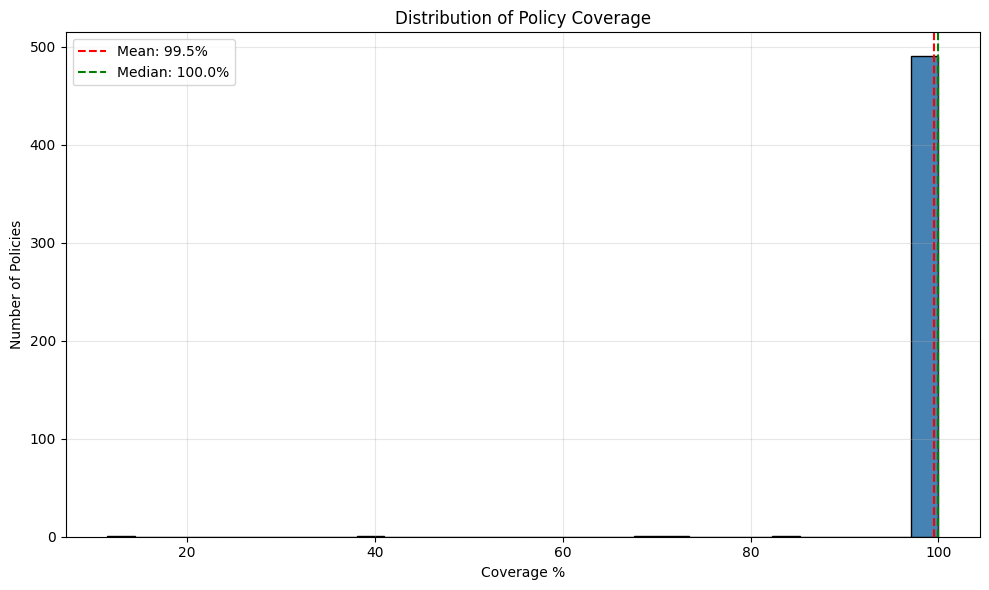

In [138]:
# First, analyze policy coverage distribution
policy_coverage = analyze_policy_coverage(eval_filtered_df)


=== Policy Coverage Statistics ===
Total evaluations: 26
Total policies: 495
Mean coverage: 99.5%
Median coverage: 100.0%
Min coverage: 11.5% (daphne.navigation.earlyterm.half.2.07-28:v99)
Max coverage: 100.0% (jacke.sky_random_nav_grid_spiral_20250725_154829:v147)
Std dev: 5.2%


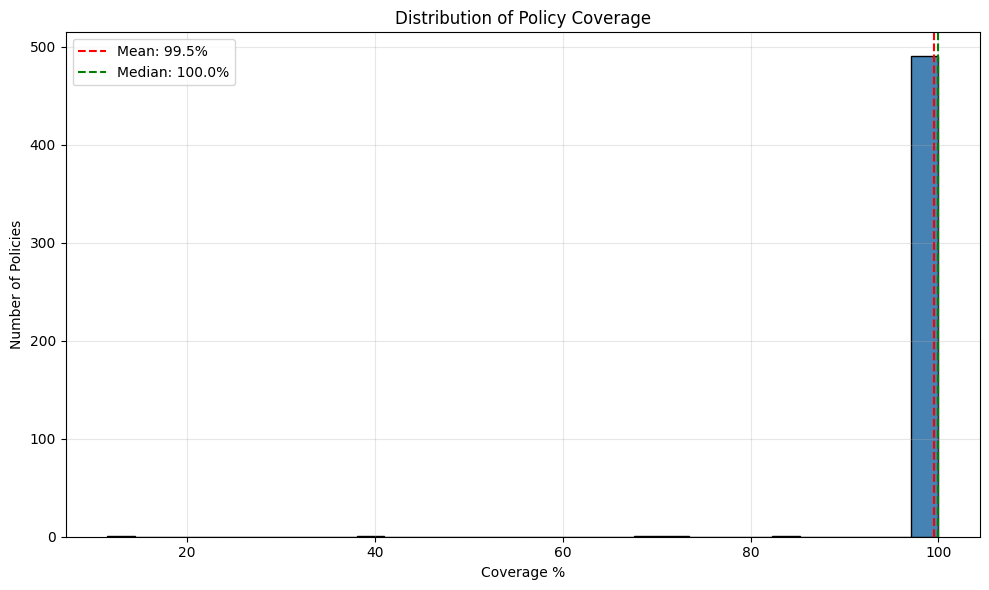


=== Coverage Filtering Results ===
Minimum coverage threshold: 75.0%
Policies kept: 491 / 495
Policies dropped: 4

=== Dropped Policies (coverage < 75.0%) ===
  daphne.navigation.earlyterm.half.2.07-28:v99: 11.5%
  jacke.sky_nav_grid_spiral_20250725_154838:v223: 38.5%
  jacke.sky_nav_grid_20250725_154819:v39: 69.2%
  jacke.sky_nav_grid_20250725_154808:v99: 73.1%

=== Overall Coverage Impact ===
Before filtering: 99.5% coverage
After filtering: 100.0% coverage
Coverage improvement: +0.4 percentage points


In [139]:
# Filter to keep only policies with at least 75% coverage
df_filtered = filter_by_coverage(eval_filtered_df, min_coverage=75.0)

In [140]:
df_filtered

,jacke.sky_random_nav_grid_spiral_20250725_154829:v147,jacke.sky_nav_spiral_20250725_154737:v39,jacke.sky_nav_spiral_20250725_154729:v235,jacke.sky_nav_base_20250725_143311:v231,jacke.sky_nav_spiral_20250725_154737:v195,jacke.sky_random_nav_grid_spiral_20250725_154829:v155,jacke.sky_random_nav_grid_spiral_20250725_154829:v159,daphne.navigation.earlyterm.half.2.07-28:v83,jacke.sky_nav_mainbase_20250725_174858:v51,jacke.sky_nav_spiral_20250725_154729:v135,...,daphne.navigation.earlyterm.half.2.07-28:v63,jacke.sky_nav_base_20250725_143311:v63,jacke.sky_nav_grid_20250725_154808:v139,jacke.sky_nav_grid_spiral_20250725_154838:v211,jacke.sky_nav_spiral_20250725_154737:v167,jacke.sky_nav_grid_20250725_154819:v47,jacke.sky_nav_base_20250725_143311:v31,jacke.sky_nav_grid_20250725_154819:v43,jacke.sky_nav_grid_20250725_154808:v79,jacke.sky_nav_spiral_20250725_154729:v107
navigation/corridors,0.999,0.999,0.666,0.999,0.666,0.999,0.999,0.999,0.999,0.999,...,0.666,0.999,0.999,0.666,0.666,0.666,0.666,0.999,0.666,0.999
navigation/cylinder,0.999,0.999,0.666,0.999,0.666,0.999,0.999,0.999,0.999,0.999,...,0.999,0.999,0.999,0.999,0.666,0.666,0.999,0.999,0.999,0.999
navigation/cylinder_easy,0.666,0.999,0.999,0.999,0.666,0.999,0.999,0.999,0.999,0.999,...,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999
navigation/emptyspace_outofsight,0.999,0.666,0.999,0.666,0.999,0.333,0.999,0.999,0.999,0.999,...,0.999,0.999,0.999,0.999,0.999,0.666,0.999,0.666,0.666,0.999
navigation/emptyspace_sparse,0.666,0.666,0.666,0.333,0.666,0.333,0.999,0.666,0.999,0.666,...,0.333,0.666,0.666,0.333,0.666,0.666,0.333,0.999,0.666,0.999
navigation/emptyspace_sparse_medium,0.666,0.333,0.333,0.000,0.000,0.666,0.333,0.333,0.333,0.000,...,0.000,0.000,0.333,0.000,0.000,0.666,0.333,0.999,0.000,0.999
navigation/emptyspace_withinsight,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.666,0.999,0.999,...,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999
navigation/honeypot,0.999,0.999,0.666,0.333,0.999,0.333,0.666,0.999,0.999,0.999,...,0.666,0.666,0.999,0.999,0.999,0.999,0.666,0.333,0.666,0.999
navigation/knotty,0.333,0.666,0.999,0.666,0.999,0.666,0.666,0.666,0.666,0.999,...,0.666,0.999,0.999,0.666,0.999,0.666,0.666,0.999,0.999,0.666
navigation/labyrinth,0.000,0.000,0.000,0.999,0.000,0.999,0.000,0.666,0.999,0.999,...,0.000,0.999,0.000,0.999,0.999,0.000,0.999,0.000,0.999,0.999


Running factor analysis on 491 policies across 26 evaluations


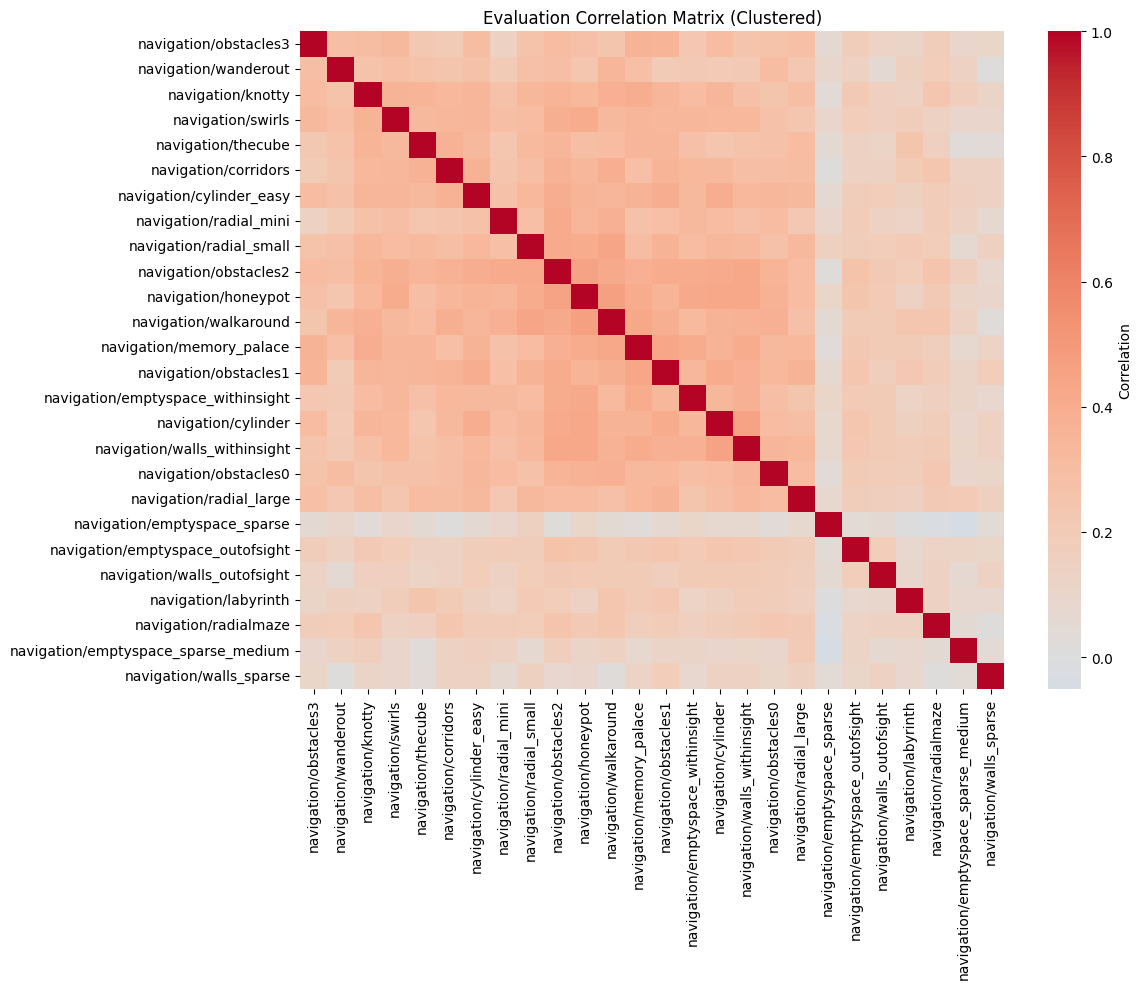


Performing cross-validated factor selection...
  Factors:  1, MSE: 0.0545, Var Explained: 0.3964
  Factors:  2, MSE: 0.0530, Var Explained: 0.4132
  Factors:  3, MSE: 0.0513, Var Explained: 0.4323
  Factors:  4, MSE: 0.0498, Var Explained: 0.4487
  Factors:  5, MSE: 0.0485, Var Explained: 0.4629
  Factors:  6, MSE: 0.0470, Var Explained: 0.4799
  Factors:  7, MSE: 0.0456, Var Explained: 0.4957
  Factors:  8, MSE: 0.0448, Var Explained: 0.5047
  Factors:  9, MSE: 0.0433, Var Explained: 0.5203
  Factors: 10, MSE: 0.0420, Var Explained: 0.5350
  Factors: 15, MSE: 0.0358, Var Explained: 0.6032
  Factors: 20, MSE: 0.0278, Var Explained: 0.6917
  Factors: 25, MSE: 0.0260, Var Explained: 0.7118


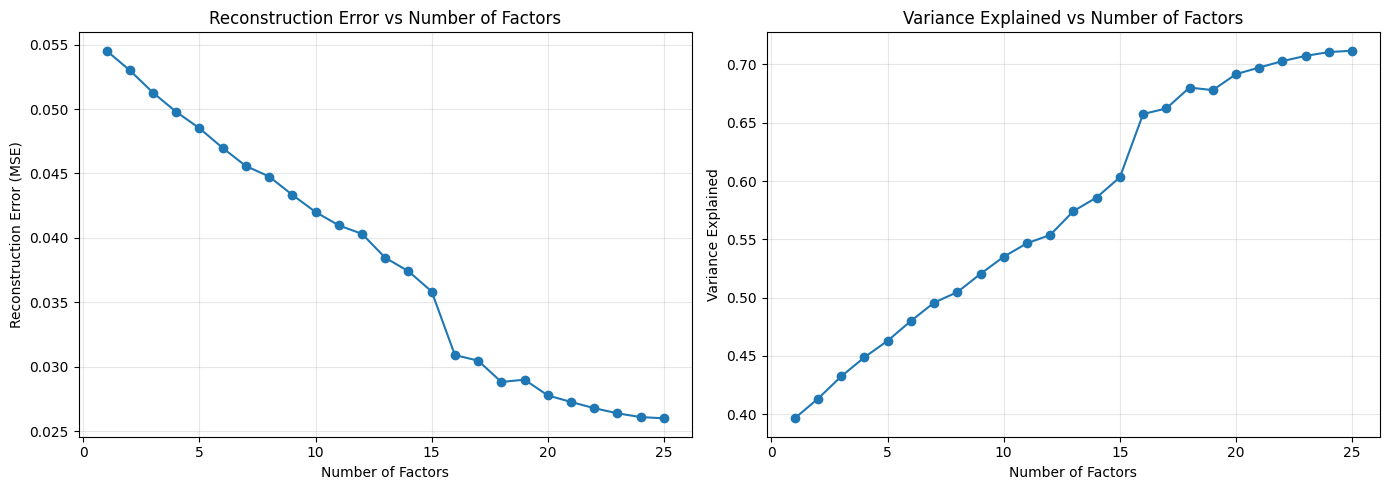


Optimal number of factors: 20

Fitting final model with 20 factors...


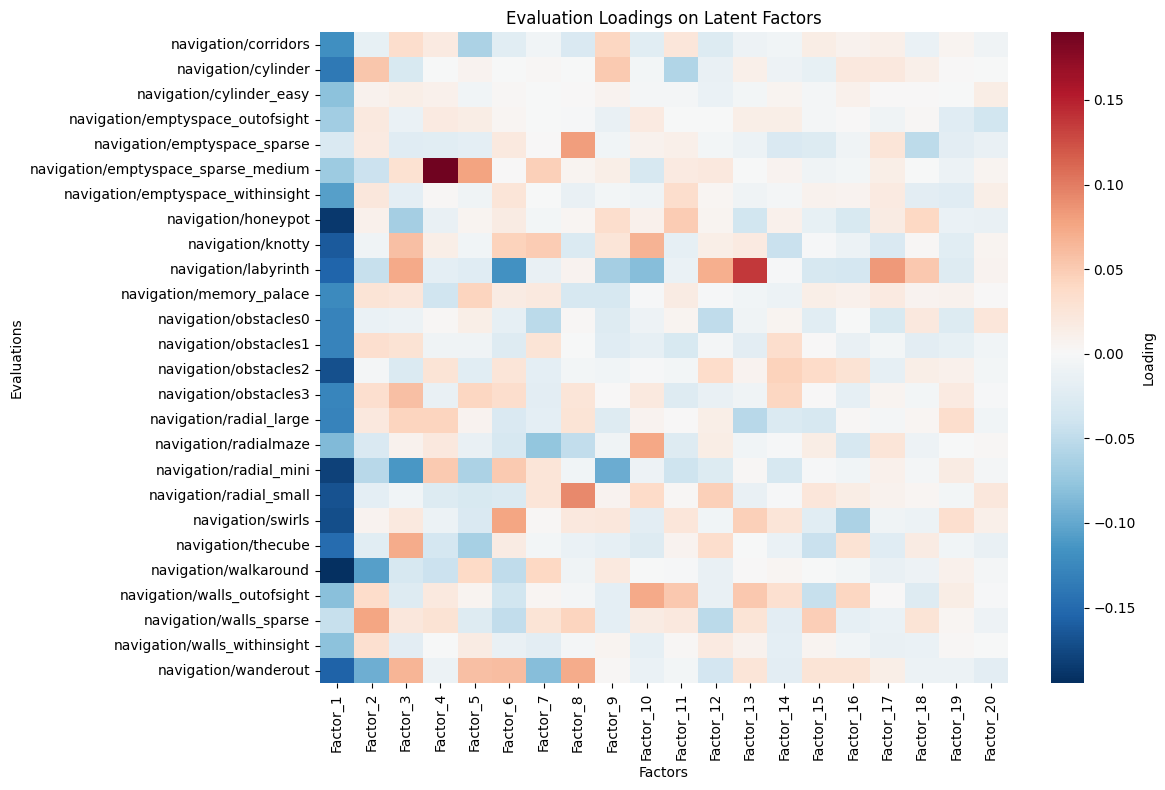


Top evaluations for each factor:

Factor_1:
  navigation/walkaround: 0.195
  navigation/honeypot: 0.187
  navigation/radial_mini: 0.180
  navigation/swirls: 0.172
  navigation/obstacles2: 0.170

Factor_2:
  navigation/walkaround: 0.107
  navigation/wanderout: 0.095
  navigation/walls_sparse: 0.076
  navigation/radial_mini: 0.055
  navigation/cylinder: 0.054

Factor_3:
  navigation/radial_mini: 0.112
  navigation/labyrinth: 0.074
  navigation/thecube: 0.071
  navigation/honeypot: 0.066
  navigation/wanderout: 0.065

Factor_4:
  navigation/emptyspace_sparse_medium: 0.190
  navigation/radial_mini: 0.051
  navigation/radial_large: 0.044
  navigation/walkaround: 0.042
  navigation/memory_palace: 0.040

Factor_5:
  navigation/emptyspace_sparse_medium: 0.078
  navigation/thecube: 0.065
  navigation/radial_mini: 0.062
  navigation/corridors: 0.062
  navigation/wanderout: 0.059

Factor_6:
  navigation/labyrinth: 0.117
  navigation/swirls: 0.076
  navigation/wanderout: 0.060
  navigation/radial

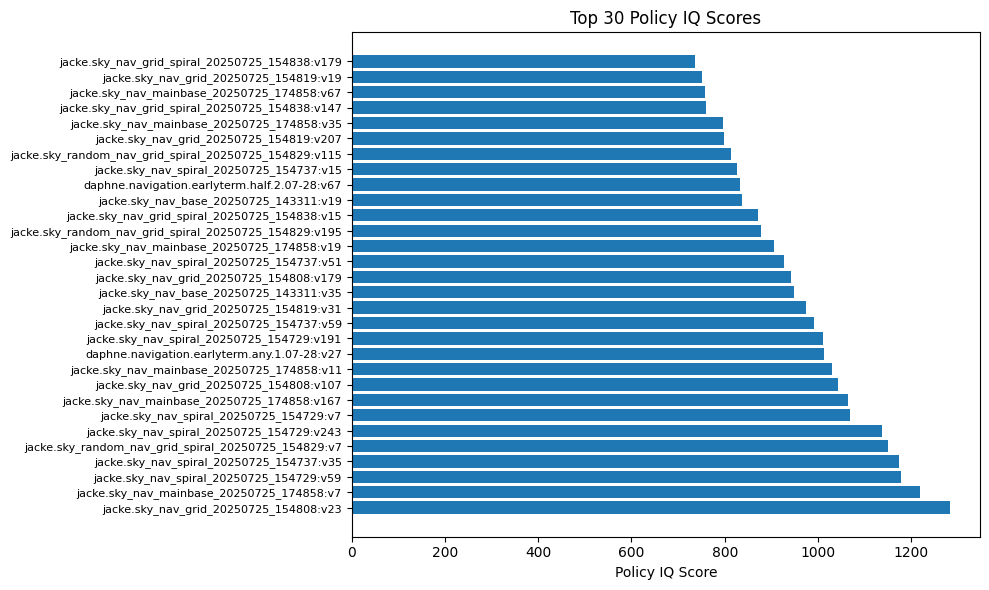

In [141]:
# Run factor analysis on the filtered data (only well-tested policies)
# No need to specify eval_filter since we already filtered the evaluations
results_filtered = run_factor_analysis(df_filtered)